## CGAN

Le but de ce TP est de vous apprendre une architecture un peu plus avancé pour les GAN : les Conditional GAN (ou CGAN).

## Prérequis

Il est nécessaire d'avoir fait le TP GAN et fortement recommandé d'avoir le TP Classes.

## Introduction aux CGAN

Comme vous avez pu le voir dans la forma GAN, les GAN c'est super, mais ça a plein de problèmes. Notamment, il est possible qu'il se mette à générer que des images très similaires - c'est le problème du mode collapse. Un autre "problème", c'est qu'on a aucun contrôle sur l'output : on ne peut pas lui préciser ce qu'on veut lui faire générer ce qu'on veut une fois qu'il a été entrainé.

Mais ne perdez pas espoir, il existe une super solution à ces problèmes : labéliser les données. Et bien, un CGAN c'est exactement, un GAN avec des labels.

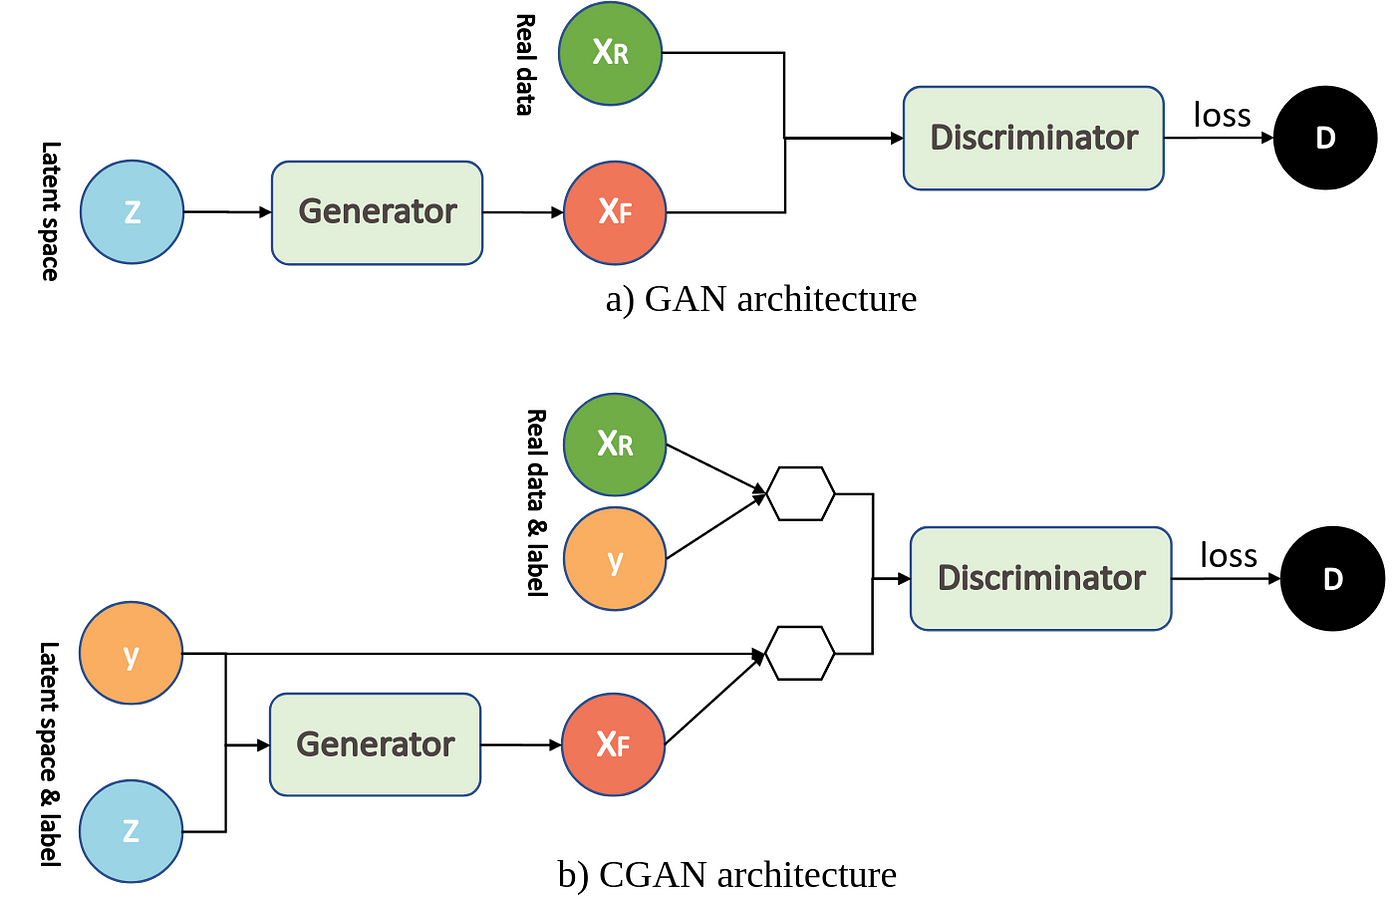

On va donc essayer dans ce TP de faire un CGAN qui génère des chiffres (comme dans la forma GAN) !

## Les imports


On va d'abord importer les librairies nécessaires dont les classiques numpy, matplotlib ainsi que Pytorch (quand même....) et certains de ses modules.

In [15]:
import torch
from torchvision.datasets import MNIST
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

## Préparation des données


Importons maintenant le dataset. Pour ça on va importer un dataset déjà inclu dans PyTorch, MNIST (que vous devez commencer à connaître maintenant !).


In [23]:
BATCH_SIZE = 64

tensor_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((32, 32)),
                                       transforms.Normalize((0.5), (0.5))])
train_dataset = MNIST('.', train = True, transform = tensor_transform, download=True)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

On peut regarder à quoi ressemble les élèments de notre dataset : chaque image à un label associé.

In [ ]:
test_batch = next(iter(train_dataset))
test_image = test_batch[0].permute(0, 2, 3, 1)
test_label = test_batch[1]
fig = plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.title(str(int(test_label[i])))
  # On oublie pas de faire image * 0.5 + 0.5 pour revenir dans [0,1]
  plt.imshow(test_image[i]*0.5+0.5)
plt.show()

## Pytorch et les GPUs...





Pytorch a besoin qu'on lui précise avec quel appareil on travaille (CPU ou GPU par exemple).

Du coup, ici on choisit le meilleur appareil disponible (généralement GPU, sinon CPU).

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Exercice 1 : Le discriminateur

Ici, on va faire presque comme dans le TP GAN, sauf qu'on va d'abord avoir besoin de concaténer l'image et son label avant de les donner au discriminateur. Pour ça, on peut utiliser la fonction torch.cat puis reshape ce qu'on obtient pour en faire une image.
Pour traiter le label en quelque chose de plus utilisable, on peut utiliser nn.functional.one_hot()


A vous de l'implémenter !
<details>
<summary>Tips</summary>
Si vous voulez pas trop vous prendre la tête, vous pouvez utiliser des couches denses. La couche nn.Embedding peut servir sinon.
</details>



In [29]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    ...

  def forward(...):
    return ...


## Exercice 2 : Le générateur

De même, le générateur va être très proche du TP GAN, il suffit juste de concaténer le vecteur latent avec les labels. On pourra encore une fois utiliser la fonction torch.cat.
A vous de l'implémenter !
<details>
<summary>Tips</summary>
Si vous voulez pas trop vous prendre la tête, vous pouvez utiliser des couches denses.
</details>


In [33]:
LATENT_DIM = 100

class Generator(nn.Module):
  def __init__(self, latent_dim):
    super(Generator, self).__init__()
    ...

  def forward(...):
    return ...


## Exercice 3 : Le train step

Ici, on va définir une training step pour l'entrainement de nos réseaux. Encore une fois, il ne s'agit pas de réinventer l'eau chaude, il s'agit d'un entrainement classique pour un GAN. Si vous avez un doute, n'hésitez pas à jeter un coup d'oeil au TP GAN.

**/!\** Afin d'avoir un réseau qui marche bien, il va également falloir apprendre à notre discriminateur à reconnaitre l'association (vraie image, faux label) comme faux.
On peut pour cela générer des labels qui ne correspondent pas aux vraies images, faire une prédiction sur cette paire avec le discriminateur et calculer la loss de cette prédiction.

In [34]:
def train_step(real_images, labels, generator, discriminator, loss, g_opt, d_opt):
  global LATENT_DIM
  batch_size = real_images.size(dim=0)


  noise = torch.randn(size = (batch_size, LATENT_DIM)).to(device)
  fake_images = ...

  ### On entraine le discriminateur

  discriminator.zero_grad()

  fake_images_predictions = ...
  real_images_predictions = ...


  fake_labels = torch.zeros_like(fake_images_predictions)
  fake_labels = fake_labels.type_as(real_images)
  real_labels = torch.ones_like(real_images_predictions)
  real_labels = real_labels.type_as(real_images)

  ### On calcule la loss pour les vraies et les fausses images


  disc_loss = ...

  ### Backpropagation
  disc_loss.backward()
  d_opt.step()
  #d_opt.zero_grad()



  ### On entraine le générateur

  generator.zero_grad()

  fake_images = ...
  fake_images_predictions = ...

  real_labels = torch.ones_like(fake_images_predictions)
  real_labels = real_labels.type_as(real_images)

  ### On calcule la loss pour le générateur

  gen_loss = ...

  ### Backpropagation

  gen_loss.backward()
  g_opt.step()
  #g_opt.zero_grad()
  return gen_loss,disc_loss

## Exercice 4 : Le train

On code la fonction d'entraînement principale.
Il reste à compléter la loss et les optimisateurs à utiliser, typiquement ici la `BCELoss()` et `Adam(parameters,lr=2e-4,betas = (0.5, 0.5)` (n'oubliez pas les parenthèses pour la loss !).

Dans un premier temps, on peut prendre les mêmes optimiseurs pour les deux quitte à adapter pour tester après.

In [35]:
def train(dataset,generator,discriminator,epochs,fixed_noise,fixed_labels):

  ###A compléter###
  loss = ...
  g_opt = ...
  d_opt = ...

  Lgen_loss = []
  Ldisc_loss = []
  X = []
  j = 0

  for epoch in range(epochs):
    progress_bar = tqdm(dataset)
    ## Vu que c'est un dataloader, on ne peut itérer directement dessus avec son indice. On va juste prendre à chaque fois batch par batch.
    for _,batch in enumerate(progress_bar):
        j += 1
        real_images = batch[0].to(device)
        labels = batch[1].to(device)
        gen_loss, disc_loss = ...
        X.append(j)
        Lgen_loss.append(gen_loss.item())
        Ldisc_loss.append(disc_loss.item())

        progress_bar.set_description(f"Epoch {epoch+1}/{epochs} | Gen Loss: {gen_loss} | Disc Loss: {disc_loss}")

    clear_output(wait=False)
    generate_and_save_plots(X, Lgen_loss, Ldisc_loss) # Définie après, pour générer les courbes des loss
    summarize_performance(generator,fixed_noise,fixed_labels) # Définie après, pour afficher les images générées

## L'affichage à chaque epoch


Petite fonction qui affiche les images obtenues à chaque epoch. On va **afficher** 25 images avec la même seed (toujours du même vecteur latent) pour voir l'amélioration progressive de l'image. Ce n'est pas de l'overfitting sur un seul vecteur car on **entraîne** bien à partir de vecteurs différents à chaque fois avant.

On affiche aussi après chaque epoch les courbes des loss du générateur et du discriminateur pour suivre l'entraînement et l'arrêter si on constate un souci.

In [40]:
def summarize_performance(generator,fixed_noise,fixed_labels):
  fake_images = generator(fixed_noise,fixed_labels).detach().cpu()
  fake_images = torch.permute(fake_images, (0, 2, 3, 1))
  fig = plt.figure(figsize=(12,12))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(fake_images[i]*0.5+0.5)
    plt.title(str(int(fixed_labels[i])))
  plt.show()

In [37]:
def generate_and_save_plots(X, Lgen_loss, Ldisc_loss):
    fig = plt.figure(figsize=(4,4))
    plt.plot(X,Lgen_loss, label = 'gen_loss')
    plt.plot(X,Ldisc_loss, label = 'disc_loss')
    plt.legend()
    plt.show()

## Ici vous lancez tout!

Choisissez le nombre d'epochs que vous voulez. Ici une vingtaine d'epochs peut suffire, on va pas attendre 3h quand même.

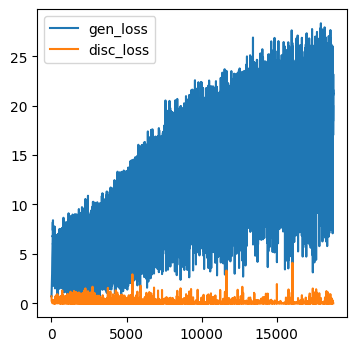

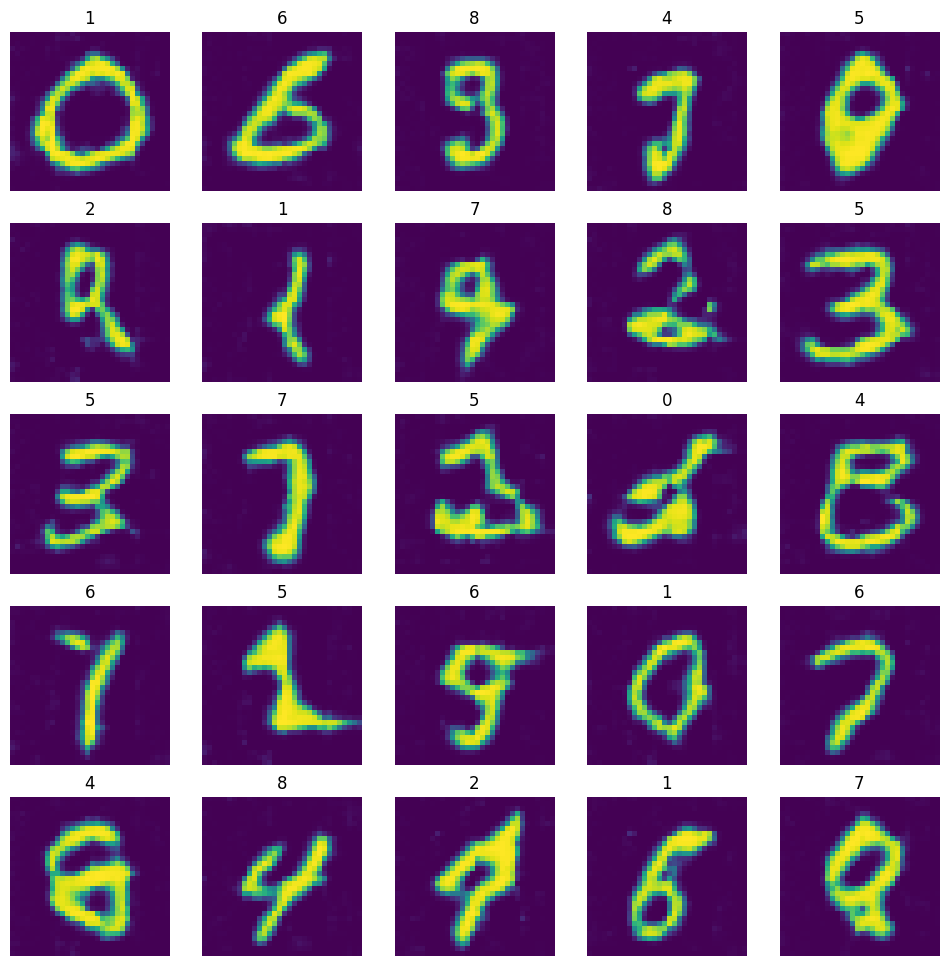

In [41]:
generator = ...
discriminator = ...

EPOCHS = 20
fixed_noise = torch.randn(size=(25, LATENT_DIM)).to(device)
fixed_labels = torch.randint(0, 9, (25,)).to(device)
train(train_dataset,generator,discriminator,EPOCHS,fixed_noise,fixed_labels)

Et voilà, maintenant vous êtes des experts en CGAN ! Adieu tous les problèmes de mode collapse et bienvenue aux images labélisées !